In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot as plt
from tqdm import tqdm
import pathlib
import datetime
import dateutil

In [2]:
def load_data(path):
    df = pd.read_excel(path)
    title = df.iloc[3]['Unnamed: 0']
    df = df.drop([2, 3])
    data_groups = {}
    current_group = df.iloc[0].values[0]

    for index, value in zip(df.iloc[0].index, df.iloc[0].values):
        if (pd.isna(value)):
            data_groups[current_group].append(index)
        else:
            current_group = value
            data_groups[current_group] = [index]

    data_dfs = []
    index = pd.to_datetime(df['Unnamed: 0'][2:-3], dayfirst=True)

    for group, cols in tqdm(zip(list(data_groups.keys())[1:], list(data_groups.values())[1:])):
        data_df = df[cols].copy()
        data_df.columns = data_df.iloc[1].values
        data_df = data_df.drop([0, 1])[:-3]
        data_df = data_df.set_index(index)
        data_df.index = pd.to_datetime(data_df.index)
        data_df.index.names = ['timestamp']
        data_dfs.append((group, data_df))
    
    return title, data_groups, data_dfs

In [6]:
path = '../samples/report1.xlsx'

In [7]:
title, data_groups,data_dfs = load_data(path)

10it [00:00, 123.46it/s]


In [8]:
i = data_dfs[0][1].index.get_indexer(['2024-06-01 22:00:00'])[0]
data_dfs[0][1][i-2:i+2]

,Итого,Прямое,Обратное
timestamp,,,


In [14]:
# data = data_dfs[0][1]['Итого'].astype(float)

# start = pd.Timestamp('2024-06-01 22:00:00')
# end = pd.Timestamp('2024-06-01 22:00:00')

# i_before = data.index.get_indexer([start]) - 1
# i_after = data.index.get_indexer([end]) + 1

# data.iloc[i_before] = np.nan
# data.iloc[i_after] = np.nan

# interpolation = data[start - pd.Timedelta(hours=12):end + pd.Timedelta(hours=12)
#      ].interpolate(method='spline', order=2)

# prediction_index =  data.index[i_before[0]:i_after[0] + 1]
# data_dfs[0][1][prediction_index, 'predict'] = interpolation[prediction_index]

TypeError: unhashable type: 'DatetimeIndex'

<Axes: xlabel='timestamp'>

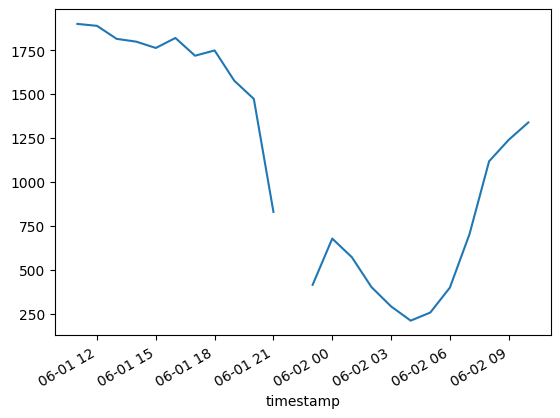

In [ ]:
# data[start - pd.Timedelta(hours=12):end + pd.Timedelta(hours=12)].plot()

In [ ]:
# data_dfs[0][1]['Итого'].min()

12

In [115]:
def predict(df, title):
    predicted_df = pd.DataFrame(index=df.index)
    for col in df.columns:
        data = df[col].to_frame().sort_index()
        data['is_nan'] = data[col].isna().astype(int)
        data['group'] = (data['is_nan'].diff() == 1).cumsum()
        data = data.reset_index()
        nan_intervals = data[data['is_nan'] == 1].groupby(
            'group').agg(start=('timestamp', 'first'), end=('timestamp', 'last'))
        data = data.set_index('timestamp')
        data = data.drop(['is_nan', 'group'], axis=1)
        data = data.astype(float)
        nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start']
        if (len(nan_intervals) == 0):
            predicted_df[f'{title} - {col} - predict'] = pd.Series(
                    index=predicted_df.index)
            continue
        for interval in nan_intervals.itertuples():
            if (len(interval) == 0):
                predicted_df[f'{col} - predict'] = pd.Series(
                    index=predicted_df.index)
                continue
            start, end, duration = interval.start, interval.end, interval.duration
            
            if (duration < pd.Timedelta(hours=5)):
                i_before = data.index.get_indexer([start]) - 1
                i_after = data.index.get_indexer([end]) + 1
                data.iloc[i_before] = np.nan
                data.iloc[i_after] = np.nan
                interpolation = data[start - pd.Timedelta(hours=12):end + pd.Timedelta(hours=12)
                     ].interpolate(method='spline', order=2)
                prediction_index =  data.index[i_before[0]:i_after[0] + 1]
                predicted_df.loc[prediction_index,
                                 f'{title} - {col}: predict'] = interpolation[prediction_index]
            
            train_end = data[:start].index[-2]
            train_start = (
                train_end - pd.Timedelta(days=train_end.weekday())).normalize()
            train_start = data.iloc[data.index.get_indexer(
                [train_start], method='nearest')[0]].name
            train = data[train_start:train_end]
            seasonal_periods = 24
            eps = 10e-05
            if len(train) < seasonal_periods * 2:
                train = pd.concat(
                    [train, data[:train_start][len(train) - (seasonal_periods*2+1):-1]]).sort_index()
            train = np.log(train.replace(0,1) + eps)
            fit = ExponentialSmoothing(
                train.values,
                trend=None,
                seasonal='mul',
                seasonal_periods=seasonal_periods,
                damped_trend=False,
            ).fit()
            predict_index = data.index[data.index.get_loc(
                start):data.index.get_loc(end) + 2]
            nan_counts = len(data[start:end])
            data[train_start:train_end] = data[train_start:train_end] + eps
            predicted_df.loc[predict_index,
                                 f'{title} - {col}: predict'] = np.exp(fit.forecast(int(nan_counts + 1)))
                
    return predicted_df


resulted_df = pd.DataFrame(index=data_dfs[0][1].index)
for name, df in data_dfs:
    predicted = predict(df, name)
    resulted_df = pd.concat([resulted_df, predicted], axis=1)

In [116]:
data_dfs[0][1]['Обратное'] + 10e-05

timestamp
2024-01-01 00:59:59     65.0001
2024-01-01 01:59:59    134.0001
2024-01-01 02:59:59    106.0001
2024-01-01 03:59:59     73.0001
2024-01-01 04:59:59     42.0001
                         ...   
2024-12-31 19:59:59    284.0001
2024-12-31 20:59:59    212.0001
2024-12-31 21:59:59    186.0001
2024-12-31 22:59:59    130.0001
2024-12-31 23:59:59     47.0001
Name: Обратное, Length: 8771, dtype: object

In [117]:
for name, df in data_dfs:
    print(name)

Общая интенсивность автомобилей
Легковые (до 6 м)
Малые груз. (6-9 м)
Грузовые (9-13 м)
Груз. большие (13-22 м)
Автопоезда (22-30 м)
Автобусы
Мотоциклы
Скорость, км/ч
Загрузка, %


In [118]:
# = pd.DataFrame(index=data_dfs[0][1].index)
# resulted_df['Общая интенсивность автомобилей - Итого: predict'][~resulted_df['Общая интенсивность автомобилей - Итого: predict'].isna()]
# for name, df in data_dfs:
#     resulted_df = pd.concat([resulted_df, df], axis=1)
    

In [119]:
info_row = [np.nan]
for col_name, cols in zip(list(data_groups.keys())[1:], list(data_groups.values())[1:]):
    info_row += [col_name] * len(cols)

In [120]:
list(zip(info_row, resulted_df.columns))

[(nan, 'Общая интенсивность автомобилей - Итого - predict'),
 ('Общая интенсивность автомобилей',
  'Общая интенсивность автомобилей - Прямое - predict'),
 ('Общая интенсивность автомобилей',
  'Общая интенсивность автомобилей - Обратное: predict'),
 ('Общая интенсивность автомобилей', 'Легковые (до 6 м) - Итого - predict'),
 ('Легковые (до 6 м)', 'Легковые (до 6 м) - Прямое - predict'),
 ('Легковые (до 6 м)', 'Легковые (до 6 м) - Обратное: predict'),
 ('Легковые (до 6 м)', 'Малые груз. (6-9 м) - Итого - predict'),
 ('Малые груз. (6-9 м)', 'Малые груз. (6-9 м) - Прямое - predict'),
 ('Малые груз. (6-9 м)', 'Малые груз. (6-9 м) - Обратное: predict'),
 ('Малые груз. (6-9 м)', 'Грузовые (9-13 м) - Итого - predict'),
 ('Грузовые (9-13 м)', 'Грузовые (9-13 м) - Прямое - predict'),
 ('Грузовые (9-13 м)', 'Грузовые (9-13 м) - Обратное: predict'),
 ('Грузовые (9-13 м)', 'Груз. большие (13-22 м) - Итого - predict'),
 ('Груз. большие (13-22 м)', 'Груз. большие (13-22 м) - Прямое - predict'),
 ('

In [121]:
len(info_row), resulted_df.shape

(29, (8771, 28))

In [122]:
resulted_df = resulted_df.reset_index()
resulted_df.loc[-1] = info_row

C:\Users\riabt\AppData\Local\Temp\ipykernel_24540\4257859202.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resulted_df.loc[-1] = info_row


In [123]:
resulted_df

,timestamp,Общая интенсивность автомобилей - Итого - predict,Общая интенсивность автомобилей - Прямое - predict,Общая интенсивность автомобилей - Обратное: predict,Легковые (до 6 м) - Итого - predict,Легковые (до 6 м) - Прямое - predict,Легковые (до 6 м) - Обратное: predict,Малые груз. (6-9 м) - Итого - predict,Малые груз. (6-9 м) - Прямое - predict,Малые груз. (6-9 м) - Обратное: predict,...,Автобусы - Итого - predict,Автобусы - Прямое - predict,Автобусы - Обратное: predict,Мотоциклы - Итого - predict,Мотоциклы - Прямое - predict,Мотоциклы - Обратное: predict,"Скорость, км/ч - Прямое - predict","Скорость, км/ч - Обратное: predict","Загрузка, % - Прямое - predict","Загрузка, % - Обратное: predict"
0,2024-01-01 00:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 01:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 02:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 03:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 04:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,2024-12-31 20:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8768,2024-12-31 21:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8769,2024-12-31 22:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8770,2024-12-31 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
resulted_df.index = resulted_df.index + 1
resulted_df = resulted_df.sort_index()

In [125]:
save_path = str(f'{pathlib.Path(path).parent}/output/{title.replace("/", "-").replace(" ", "_")}__{datetime.datetime.now().strftime("%d-%m-%Y__%H-%M-%S")}.xslx')
save_path

'..\\samples/output/км_32+000_а-д_А-146_Краснодар-Верхнебаканский___31-03-2025__00-51-51.xslx'

In [126]:
with pd.ExcelWriter(path, mode='a', if_sheet_exists='replace') as writer:
    resulted_df = resulted_df.reset_index().rename(columns={'timestamp': 'Дата'})
    resulted_df['Дата'] = resulted_df['Дата'].astype(str)
    resulted_df.to_excel(excel_writer=writer,
                         sheet_name='Результаты')